In [ ]:
# Installing imortant packages
!pip install transformers
!pip install torch torchvision
!pip install pytorch_wavelets

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import ViTModel
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

from pytorch_wavelets import DWTForward

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 2.6 MB/s eta 0:00:00


### 1. Data Loading and Window Sampling  
The **Jena Climate dataset** contains weather data collected between January 1st, 2009 and December 31st, 2016.  
It includes 14 different environmental quantities (such as air temperature, atmospheric pressure, humidity, and wind direction), all recorded every 10 minutes.

#### **Data Preprocessing and Sliding Window Creation**

- **Load dataset:** Reads the Jena Climate CSV containing all recorded features.
- **Select numeric columns:** Extracts only the 14 numerical measurements for modeling.
- **Standardize features:** Applies z-score normalization so each feature (e.g., temperature, pressure) has mean 0 and standard deviation 1, ensuring comparability.
- **Sliding window creation:** Divides the time series into overlapping windows of consecutive measurements. The `window_size` parameter determines how many time steps are included in each window (in our case, 24 consecutive readings for a 4-hour window as data is collected per 10 minutes). The `step` controls how far the window moves forward at each step.
- **Random sampling of windows:** Optionally, a fraction of all generated windows can be sampled to reduce dataset size and speed up downstream training.

#### Example:
Suppose your numerical data is `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]`,  
with `window_size = 4` and `step = 2`.  
The windows formed will be:  
- `[0, 1, 2, 3]`  
- `[2, 3, 4, 5]`  
- `[4, 5, 6, 7]`  
- `[6, 7, 8, 9]`  

If you sample 50%, only two random windows (out of four) are kept for modeling.

---



In [ ]:
df = pd.read_csv('/content/jena_climate_2009_2016.csv')
df_numeric = df.select_dtypes(include=[np.number])
data = (df_numeric - df_numeric.mean()) / df_numeric.std()
values = data.values


In [ ]:
# Adjustable step size for sliding windows
window_size = 24
step = 4

def create_windows(data, window_size, step):
    X = []
    for i in range(0, len(data) - window_size, step):
        X.append(data[i:i+window_size])
    return np.stack(X)

patches = create_windows(values, window_size, step)
images = patches.transpose(0, 2, 1)  # [N, features, window]

print(f"Total windows created: {images.shape[0]}")

# randomly sample a fraction of windows to further reduce dataset size
import random

def sample_windows(images, sample_fraction=0.1, seed=42):
    random.seed(seed)
    total = images.shape[0]
    sample_count = int(total * sample_fraction)
    indices = random.sample(range(total), sample_count)
    return images[indices]

# Keeping only 10% of generated windows for faster training
images = sample_windows(images, sample_fraction=0.1)

print(f"Windows after random sampling: {images.shape[0]}")


Total windows created: 140176
Windows after random sampling: 14017


### 3. Patch Size Adjustment for Vision Transformer Input

Vision Transformers (ViT) process images by dividing them into fixed-size patches (e.g., 16x16 pixels).  
To use the Jena Climate multivariate time series data as "images," we reshape them into 2D arrays (features × time window).  

Since the number of features and the window length may not be divisible exactly by the patch size, **we crop the data** so that both dimensions are divisible by the patch size. This ensures smooth division into non-overlapping patches for the ViT without padding.

- **PATCH_SIZE:** The desired patch dimension (e.g., 16).
- **n_features:** Number of features (rows in the "image").
- **window_len:** Length of the time window (columns in the "image").

We adjust the patch size if it's larger than either dimension, then crop both dimensions to multiples of `PATCH_SIZE`.  
If the dimension is already a multiple of patch size, we keep it unchanged.

This step is crucial to avoid errors or distortions during patch embedding and to keep the input shape consistent with the model architecture.

---

**Example:**  
If `n_features = 14` and `PATCH_SIZE = 16`, since 16 > 14, patch size is set to 14 to fit.  
Then, `crop_features` becomes 14 - (14 % 14) = 14 (no cropping).  
Similarly for the time window length.



In [ ]:
PATCH_SIZE = 16
n_features = images.shape[1]
window_len = images.shape[2]

if PATCH_SIZE > n_features:
    PATCH_SIZE = n_features
if PATCH_SIZE > window_len:
    PATCH_SIZE = window_len

crop_features = n_features - (n_features % PATCH_SIZE)
crop_window = window_len - (window_len % PATCH_SIZE)

if crop_features == 0:
    crop_features = n_features
if crop_window == 0:
    crop_window = window_len

images_cropped = images[:, :crop_features, :crop_window]

print(f"Cropped image dimensions before resize: {images_cropped.shape[1]} x {images_cropped.shape[2]}")


Cropped image dimensions before resize: 14 x 14


### 4. Resize and Format Windows for Vision Transformer Training

After cropping the sliding windows so both sides are divisible by the patch size, each windowed segment of our time series is treated as a grayscale image.  
Since training image models on large inputs is computationally intensive, we **downscale** each sample to a uniform 96x96 pixel resolution for efficiency and consistency.

- **Resize transform:** Converts each matrix into a PIL image, resizes to the target shape `(96, 96)`, and returns a normalized tensor suitable for PyTorch. This enables efficient training and testing by making all inputs the same size, regardless of original shape.

- **Custom PyTorch Dataset:**  
  Defines `JenaDataset` which takes windowed climate data, scales each window to `[0, 255]` for image compatibility, resizes, and converts it to a tensor.

- **Train/Test Split:**  
  The data is randomly split 80% for training, 20% for testing.  
  PyTorch `DataLoader` objects are then created to iterate over the dataset efficiently in mini-batches.

#### Why resize?
- Smaller images speed up both training and inference.
- Ensures compatibility with the input expectations of Vision Transformer architectures.
- Helps regularize the model by removing excessive input detail.

---



In [ ]:
resize_target = (96, 96)
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resize_target[::-1]),
    transforms.ToTensor(),
])

class JenaDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        from PIL import Image
        img = self.images[idx]
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img_uint8 = (img_norm * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_uint8)
        pil_img = pil_img.resize(resize_target[::-1], Image.BILINEAR)
        img_tensor = transforms.ToTensor()(pil_img)  # (1, H, W)
        return img_tensor

dataset = JenaDataset(images_cropped)
train_len = int(0.8 * len(dataset))
test_len = len(dataset) - train_len
train_ds, test_ds = random_split(dataset, [train_len, test_len])

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size=8, num_workers=2)



### 5. Custom Model: Vision Transformer (ViT) with Internal Wavelet Adapter

This model combines a **1-level discrete wavelet transform (DWT)** for time-frequency feature extraction with a **Vision Transformer (ViT)** for high-capacity modeling of windowed time series images.

#### **Key Components**

- **Wavelet Transform:**  
  The model applies a 1-level Haar wavelet transform to each input time series image.  
  The discrete wavelet transform decomposes the input into approximation coefficients (low-frequency, $(Y_l)$), and detail coefficients (high-frequency, $(Y_h)$).

**Mathematics:**  

The 1-level DWT of a signal \(x\) produces:  

$$
x(t) \xrightarrow{\text{DWT}} (Y_l, Y_h)
$$

where:

$$
Y_l = \sum_k x(k)\,\phi_{j_0, k}(t) \quad \text{(approximation)}
$$

$$
Y_h = \sum_j \sum_k x(k)\,\psi_{j, k}(t) \quad \text{(details at scale } j \text{)}
$$

*(Mallat, 1989)*


- **Wavelet Feature Fusion:**  
  All detail bands are resized and concatenated with the approximation to form a multi-channel "wavelet image".

- **Upsampling and Transformation for ViT:**  
  The wavelet image is upsampled to `224×224` (the ViT input size), and converted to a 3-channel image by averaging and repeating.

- **Vision Transformer Backbone:**  
  The processed image is fed to a pretrained ViT. The output [CLS] token summarizes the window.

- **Adapter for Anomaly Regression:**  
  A small MLP adapter projects the high-dimensional ViT output to a single anomaly score.

---

**References:**  
- Vaswani, A. et al., "Attention is All You Need", NeurIPS 2017.  
- Dosovitskiy, A. et al., "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale", ICLR 2021.  
- S. Mallat, "A Theory for Multiresolution Signal Decomposition: The Wavelet Representation," IEEE TPAMI, 1989.

---



Architecture: ViT + Wavelet Adapter

<pre>
                 +-------------------------+
                 | (B, 1, H, W) Window Img |
                 +-----------+-------------+
                             |
              +---------------+-----------------+
              |                                 |
  +-------------------+             +-------------------+
  | 1-level DWT       |             | Approx (Y_l)      |
  | (Haar, J=1)       +-----------> | [B, 1, H', W']    |
  +-------------------+             +-------------------+
              |
              v
     +----------------------------+
     | Detail Bands: 3 scales Y_h |
     +----------------------------+
              |
  +-----------v------------+
  | Resize to match Y_l    |
  +-----------+------------+
              |
  +-----------v------------+
  | Concatenate bands      |
  | [B, 4, H', W']         |
  +-----------+------------+
              |
  +-----------v------------+
  | Upsample to 224 x 224  |
  +-----------+------------+
              |
  +-----------v------------+
  | Avg + repeat to 3 ch   |
  | [B, 3, 224, 224]       |
  +-----------+------------+
              |
  +-----------v------------+
  | Vision Transformer     |
  +-----------+------------+
              |
  +-----------v------------+
  | Pooler Output (CLS)    |
  +-----------+------------+
              |
  +-----------v------------+
  | Adapter MLP (128→1)    |
  +-----------+------------+
              |
  +-----------v------------+
  | Output: Anomaly Score  |
  +-----------------------+
</pre>


In [ ]:
# 5. Model with internal wavelet transform and ViT backbone
class ViTWithWaveletAdapter(nn.Module):
    def __init__(self, vit_model):
        super().__init__()
        self.dwt = DWTForward(J=1, mode='zero', wave='haar')  # 1-level DWT
        self.vit = vit_model
        self.adapter = nn.Sequential(
            nn.Linear(self.vit.config.hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        # x: (B,1,H,W)
        Yl, Yh = self.dwt(x)
        detail_bands = Yh[0]

        processed_bands = []
        target_size = Yl.shape[2:]
        target_batch = Yl.shape[0]

        for band in detail_bands:
            while band.dim() > 4:
                band = band.squeeze(dim=-1)  # Carefully squeeze trailing dims
            # Ensure batch size match by repeating if necessary
            if band.shape[0] == 1 and target_batch > 1:
                band = band.repeat(target_batch, *[1]*(band.dim()-1))
            if band.shape[2:] != target_size:
                band = nn.functional.interpolate(band, size=target_size, mode='bilinear', align_corners=False)
            processed_bands.append(band)

        Yh_cat = torch.cat(processed_bands, dim=1)  # Concatenate on channel dim

        x_wave = torch.cat([Yl, Yh_cat], dim=1)  # Approx + details concat

        # Upsample wavelet features to 224x224 to match ViT pretrained input size
        x_wave_upsampled = nn.functional.interpolate(x_wave, size=(224, 224), mode='bilinear', align_corners=False)

        # Average channels and repeat to 3-channel for ViT input
        x_in = x_wave_upsampled.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)

        outputs = self.vit(pixel_values=x_in)
        pooled = outputs.pooler_output
        return self.adapter(pooled)

### Pretrained Vision Transformer (ViT) Model

The model uses the pretrained `"google/vit-base-patch16-224-in21k"` Vision Transformer (ViT), which has been trained on the large ImageNet-21k dataset with over 14 million images and 21,000 classes. This extensive pretraining enables the ViT to learn powerful and generalizable visual features.

Key points:  
- Splits input images into fixed 16×16 patches and processes them with self-attention layers to capture global context.  
- Using a pretrained model helps transfer learned representations to new tasks with limited labeled data.  
- The backbone is frozen during training, so only the adapter learns to specialize in anomaly detection, making training efficient.

**References:**   
- [HuggingFace Model Card](https://huggingface.co/google/vit-base-patch16-224-in21k)


### 6. Model Initialization, Loss, Optimizer, and Mixed Precision Setup

**Device Placement:**  
- Uses GPU (`'cuda'`) if available for faster computation, otherwise defaults to CPU.

**Loading Pretrained Vision Transformer:**  
- Loads the ViT backbone (`'google/vit-base-patch16-224-in21k'`) using HuggingFace Transformers.
- Freezes all weights of the pretrained ViT to prevent its backbone from being updated during training, so only the attached MLP "adapter" will learn from data.

**Model Assembly:**  
- Wraps the frozen ViT in your custom `ViTWithWaveletAdapter` architecture for wavelet-augmented anomaly detection.

**Loss and Optimizer:**  
- Uses mean squared error (MSE) loss, suitable for regression to an anomaly score.
- The Adam optimizer updates only the adapter MLP parameters (not the ViT backbone), helping the model focus on adapting high-level ViT features to our anomaly task.

**Mixed Precision Training:**  
- Activates [automatic mixed precision (AMP)](https://pytorch.org/docs/stable/notes/amp_examples.html) by creating a `GradScaler`.
  - **Mixed precision** improves training speed and reduces GPU memory by performing calculations in half-precision (FP16) where possible.
  - AMP chooses optimal precision for each operation and dynamically scales the loss to preserve numerical stability.
  - Especially effective on modern GPUs with tensor cores.

**References:**  
- [PyTorch AMP documentation](https://pytorch.org/docs/stable/notes/amp_examples.html)  
- [NVIDIA Mixed Precision Training Guide](https://docs.nvidia.com/deeplearning/performance/mixed-precision-training/index.html)

---



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_name = 'google/vit-base-patch16-224-in21k'
vit_model = ViTModel.from_pretrained(model_name)
for param in vit_model.parameters():
    param.requires_grad = False  # Freeze backbone

model = ViTWithWaveletAdapter(vit_model).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.adapter.parameters(), lr=1e-3)
scaler = torch.amp.GradScaler()

### 7. Training Loop and Saving Model

This code trains the adapter part of the model for a fixed number of epochs (10).  

- Sets the model to training mode to enable dropout and batchnorm updates.  
- Iterates over the training DataLoader batches.  
- Uses automatic mixed precision (`torch.amp.autocast`) for faster, memory-efficient training on GPUs.  
- Predicts anomaly scores and computes mean squared error (MSE) loss against zeros (training the adapter to predict zero anomaly for normal data).  
- Uses a gradient scaler (`GradScaler`) for stable mixed precision training.  
- Performs backpropagation, optimizer step, and updates scaler.  
- Tracks and prints average loss per epoch to monitor training progress.  

After training:  
- Saves the adapter weights for later use or inference.
- Plots the training loss curve to visualize convergence.



Epoch 1/10, Loss: 0.000649
Epoch 2/10, Loss: 0.000009
Epoch 3/10, Loss: 0.000011
Epoch 4/10, Loss: 0.000001
Epoch 5/10, Loss: 0.000001
Epoch 6/10, Loss: 0.000000
Epoch 7/10, Loss: 0.000000
Epoch 8/10, Loss: 0.000000
Epoch 9/10, Loss: 0.000000
Epoch 10/10, Loss: 0.000000
Adapter weights saved to vit_adapter_wavelet_jena.pth


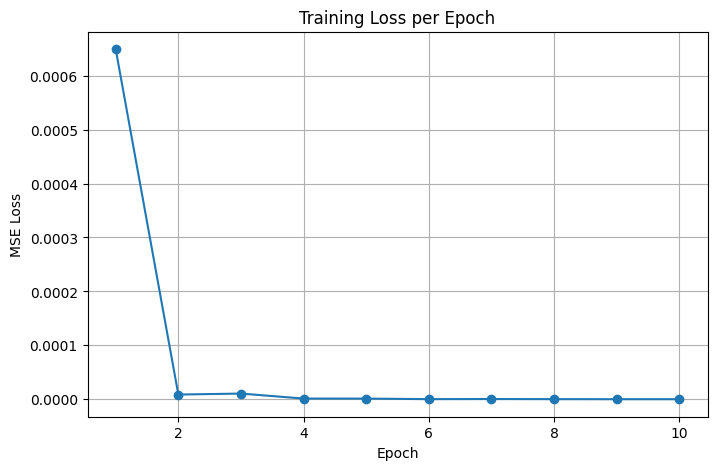

In [ ]:
# 7. Training loop (adapter trained to output zero anomaly score)
epochs = 10
epoch_losses = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    for xb in train_dl:
        xb = xb.to(device)
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            preds = model(xb)
            loss = criterion(preds, torch.zeros_like(preds))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_dl.dataset)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

# Saving adapter weights
save_path = "vit_adapter_wavelet_jena.pth"
torch.save(model.adapter.state_dict(), save_path)
print(f"Adapter weights saved to {save_path}")

# Plotting training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs+1), epoch_losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()


### 9. Model Evaluation on Test Dataset

The model is set to evaluation mode using `model.eval()` to disable training-specific layers like dropout.  
Predictions are made in a `torch.no_grad()` context to save memory and computation since gradients are not needed during evaluation.  
Automatic mixed precision (`torch.amp.autocast`) is used for efficient GPU computation.  
The model outputs anomaly scores for each test window, which are collected and plotted over the test set to visualize prediction patterns.



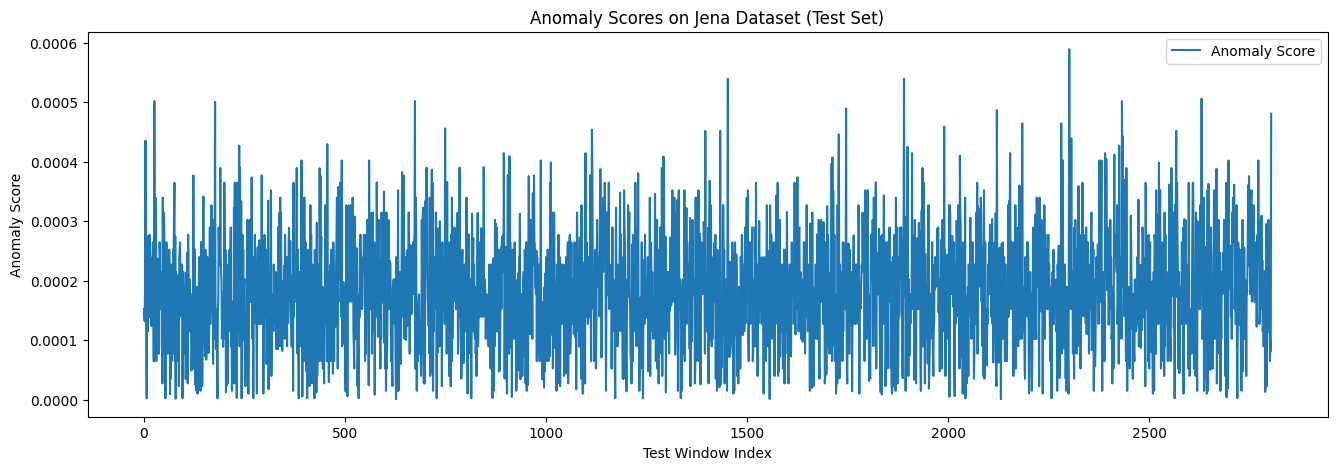

In [ ]:
model.eval()
anomaly_scores = []
with torch.no_grad():
    for xb in test_dl:
        xb = xb.to(device)
        with torch.amp.autocast(device_type='cuda'):
            preds = model(xb)
        anomaly_scores.extend(preds.squeeze().abs().cpu().numpy())

plt.figure(figsize=(16,5))
plt.plot(anomaly_scores, label="Anomaly Score")
plt.xlabel("Test Window Index")
plt.ylabel("Anomaly Score")
plt.title("Anomaly Scores on Jena Dataset (Test Set)")
plt.legend()
plt.show()

## Creation of the Sample .csv file for the testing phase

In [ ]:
import pandas as pd
import numpy as np

full_df = pd.read_csv('/content/jena_climate_2009_2016.csv')  # change path if necessary

total_rows = len(full_df)
if total_rows < 1000:
    raise ValueError("Dataset has fewer than 1000 rows!")
start_idx = np.random.randint(0, total_rows - 1000 + 1)
sampled_df = full_df.iloc[start_idx:start_idx + 1000]

sampled_df.to_csv('jena_sample_1000rows.csv', index=False)

print(f"Random 1000 consecutive rows starting at index {start_idx} saved to 'jena_sample_1000rows.csv'.")


Random 1000 consecutive rows starting at index 335938 saved to 'jena_sample_1000rows.csv'.


### Data Loading, Window Creation, and Anomaly Score Plotting (Test Phase)

- Loads the test CSV file containing the Jena Climate data sample.
- Selects numeric feature columns and standardizes them (mean 0, std 1) based on test set.
- Creates sliding windows of size 24 with step 4; pads if needed for short sequences.
- Transposes windows to shape `(N_windows, features, window_size)` for image-like input.
- Defines a custom PyTorch dataset which normalizes each window and converts it to a tensor suitable for model input.
- Uses DataLoader to batch test windows.
- Runs inference on the test data with no gradient computation and collects absolute anomaly scores.
- Calculates time indices corresponding to the center of each window for plotting.
- Plots all features faded for context alongside the scaled anomaly scores overlayed in black.
- Marks anomaly points with red circles based on the 95th percentile threshold in anomaly scores.

This pipeline visualizes where in the test time series the model detects potential anomalies.



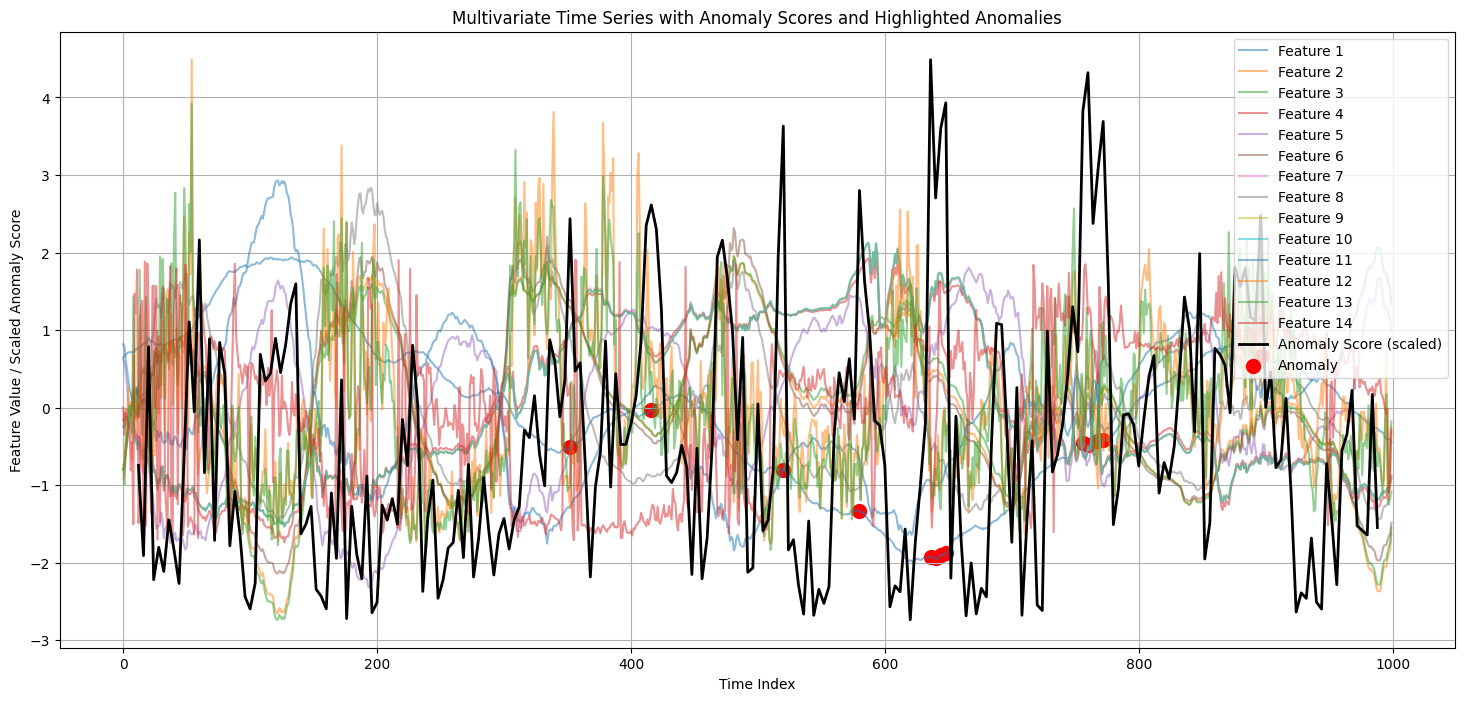

In [ ]:
# ----- Parameters -----
window_size = 24
step = 4  # Match training step size
resize_target = (96, 96)

# ----- Load and preprocess test CSV -----
test_df = pd.read_csv('/content/jena_sample_1000rows.csv')
test_numeric = test_df.select_dtypes(include=[np.number])
values = test_numeric.values

values = (values - values.mean(axis=0)) / (values.std(axis=0) + 1e-8)

# ----- Creating sliding windows -----
def create_windows(data, window_size, step):
    X = []
    length = data.shape[0]
    if length < window_size:
        pad_width = window_size - length
        data = np.vstack([data, np.zeros((pad_width, data.shape[1]))])
        length = window_size
    for i in range(0, length - window_size + 1, step):
        X.append(data[i:i+window_size])
    return np.stack(X)

test_patches = create_windows(values, window_size, step)
test_images = test_patches.transpose(0, 2, 1)  # (N_windows, features, window_size)

# ----- Dataset for test windows -----
resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(resize_target[::-1]),
    transforms.ToTensor(),
])

class TestDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32)
    def __len__(self):
        return len(self.images)
    def __getitem__(self, idx):
        img = self.images[idx]
        img_norm = (img - img.min()) / (img.max() - img.min() + 1e-8)
        img_uint8 = (img_norm * 255).astype(np.uint8)
        pil_img = Image.fromarray(img_uint8)
        pil_img = pil_img.resize(resize_target[::-1], Image.BILINEAR)
        img_tensor = transforms.ToTensor()(pil_img)  # Converting PIL image to Tensor here
        return img_tensor


test_dataset = TestDataset(test_images)
test_dl = DataLoader(test_dataset, batch_size=8, num_workers=2)

# Predict anomaly scores for test windows
scores = []
with torch.no_grad():
    for xb in test_dl:
        xb = xb.to(device)
        pred = model(xb)
        scores.extend(pred.squeeze().abs().cpu().numpy())

# ----- Plotting with updated time indices -----
time_series_length = values.shape[0]
num_features = values.shape[1]

# Calculating time indices for center of each window based on step=6
window_indices = np.arange(len(scores))
time_indices = window_indices * step + window_size // 2

plt.figure(figsize=(18, 8))

for feature_idx in range(num_features):
    plt.plot(range(time_series_length), values[:, feature_idx], alpha=0.5, label=f'Feature {feature_idx + 1}')

scores = np.array(scores)
scores_norm = (scores - scores.min()) / (scores.max() - scores.min() + 1e-8)
scaled_scores = scores_norm * (values.max() - values.min()) + values.min()

plt.plot(time_indices, scaled_scores, color='black', linewidth=2, label='Anomaly Score (scaled)')

threshold = np.percentile(scores, 95)
anomaly_points = time_indices[scores > threshold]
anomaly_values = values[anomaly_points.astype(int), 0]  # first feature for vertical pos

plt.scatter(anomaly_points, anomaly_values, color='red', s=100, marker='o', label='Anomaly')

plt.title('Multivariate Time Series with Anomaly Scores and Highlighted Anomalies')
plt.xlabel('Time Index')
plt.ylabel('Feature Value / Scaled Anomaly Score')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
test_df['datetime'] = pd.to_datetime(test_df['Date Time'])

# Calculating time indices for center of each window
window_indices = np.arange(len(scores))
time_indices = window_indices * step + window_size // 2

datetime_values = test_df['datetime'].values

threshold = np.percentile(scores, 95)
anomaly_mask = scores > threshold
anomaly_time_indices = time_indices[anomaly_mask]

# Clipping indices to be within range if needed
anomaly_time_indices = anomaly_time_indices[anomaly_time_indices < len(datetime_values)].astype(int)

anomaly_datetimes = datetime_values[anomaly_time_indices]

print("Detected anomaly points:")
for dt, score in zip(anomaly_datetimes, scores[anomaly_mask]):
    print(f"Time: {pd.to_datetime(dt)} - Anomaly Score: {score:.4f}")


Detected anomaly points:
Time: 2015-05-23 18:30:00 - Anomaly Score: 0.0004
Time: 2015-05-24 05:10:00 - Anomaly Score: 0.0004
Time: 2015-05-24 22:30:00 - Anomaly Score: 0.0005
Time: 2015-05-25 08:30:00 - Anomaly Score: 0.0005
Time: 2015-05-25 17:50:00 - Anomaly Score: 0.0006
Time: 2015-05-25 18:30:00 - Anomaly Score: 0.0005
Time: 2015-05-25 19:10:00 - Anomaly Score: 0.0005
Time: 2015-05-25 19:50:00 - Anomaly Score: 0.0006
Time: 2015-05-26 13:50:00 - Anomaly Score: 0.0006
Time: 2015-05-26 14:30:00 - Anomaly Score: 0.0006
Time: 2015-05-26 15:50:00 - Anomaly Score: 0.0005
Time: 2015-05-26 16:30:00 - Anomaly Score: 0.0005
Time: 2015-05-27 13:10:00 - Anomaly Score: 0.0004


/tmp/ipython-input-3825020508.py:2: UserWarning: Parsing dates in %d.%m.%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  test_df['datetime'] = pd.to_datetime(test_df['Date Time'])


### Synthetic Anomaly Injection and Evaluation Metrics

This code injects synthetic anomalies into the test data and uses several metrics to evaluate how well the model detects those anomalies.

**Synthetic Anomaly Injection:**  
- Adds artificial anomalous samples to the time series by randomly selecting points and adding scaled noise.
- Returns an augmented dataset along with a label array where 1 marks a synthetic anomaly and 0 marks normal data.
- This provides a controlled "ground truth" for evaluating model performance when real labels are unavailable.
- [Reference: Goswami et al., 2022; Alatrista-Salas et al., 2025]

---

#### Metrics & Mathematical Definitions

- **Excess Mass (EM):**  
  Measures concentration of high anomaly scores.  

  For threshold $\alpha$, EM is:  

  $$
  \mathrm{EM}(\alpha) = \mathrm{mean}(s_i : s_i \geq t_\alpha) - t_\alpha \cdot \mathrm{volume}
  $$

  where $t_\alpha$ is the anomaly score at quantile $1 - \alpha$, and *volume* is the fraction of scores above $t_\alpha$.  

  - **Significance:** Higher EM at low $\alpha$ means the model sharply identifies few high-anomaly points.


- **Mass Volume (MV):**  
  Measures the proportion of windows detected as anomalous at each threshold $\alpha$:
  $$
  \mathrm{MV}(\alpha) = \text{fraction of } (s_i \geq t_\alpha)
  $$
  - **Significance:** Shows how much data is flagged as anomalous for different thresholds; low MV at high thresholds is desirable.

- **ROC-AUC (Receiver Operating Characteristic - Area Under Curve):**  
  Evaluates if the model ranks synthetic anomalies higher than normal points:
  $$
  \mathrm{ROC}\textrm{-}\mathrm{AUC} = P(\text{model ranks anomaly higher than normal})
  $$
  - **Significance:** Values close to 1 mean strong anomaly discrimination.

---

**Why use these metrics?**

- **EM and MV** tell us how focused and selective the anomaly detector is, even if no true labels exist.
- **Synthetic injection** plus **ROC-AUC** allows quantitative measurement of detection power by treating injected points as pseudo-labels.

---

**References:**  
- [Goswami et al., 2022, "Unsupervised Model Selection for Time-series Anomaly Detection"][web:294]  
- [Alatrista-Salas et al., 2025, "Algorithms For Anomaly Detection on Time Series"][web:295]

---


In [ ]:
def inject_synthetic_anomalies(data, anomaly_fraction=0.05, anomaly_scale=5):
    n_samples, n_features = data.shape
    n_anomalies = int(anomaly_fraction * n_samples)
    np.random.seed(42)  # reproducibility

    anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
    anomalies = data[anomaly_indices].copy()

    noise = anomaly_scale * np.random.randn(n_anomalies, n_features)
    synthetic_anomalies = anomalies + noise

    augmented_data = np.vstack([data, synthetic_anomalies])
    labels = np.zeros(augmented_data.shape[0], dtype=int)
    labels[-n_anomalies:] = 1  # mark synthetic anomalies

    return augmented_data, labels

# Injecting synthetic anomalies before window creation
augmented_values, synthetic_labels = inject_synthetic_anomalies(values, anomaly_fraction=0.05, anomaly_scale=15)


In [ ]:
test_patches = create_windows(augmented_values, window_size, step)
test_images = test_patches.transpose(0, 2, 1)  # Shape: (N_windows, features, window_size)
test_dataset = TestDataset(test_images)
test_dl = DataLoader(test_dataset, batch_size=8, num_workers=2)


In [ ]:
scores = []
with torch.no_grad():
    for xb in test_dl:
        xb = xb.to(device)
        pred = model(xb)
        scores.extend(pred.squeeze().abs().cpu().numpy().ravel())

scores = np.array(scores)


In [ ]:
def excess_mass(scores, alpha_vals):
    em_scores = []
    for alpha in alpha_vals:
        threshold = np.quantile(scores, 1 - alpha)
        volume = np.mean(scores >= threshold)
        mass = np.mean(scores[scores >= threshold])
        em = mass - threshold * volume
        em_scores.append(em)
    return np.array(em_scores)

def mass_volume(scores, alpha_vals):
    mv_scores = []
    for alpha in alpha_vals:
        threshold = np.quantile(scores, 1 - alpha)
        volume = np.mean(scores >= threshold)
        mv_scores.append(volume)
    return np.array(mv_scores)

from sklearn.metrics import roc_auc_score


alpha_range = np.linspace(0.01, 0.1, 10)
em = excess_mass(scores, alpha_range)
mv = mass_volume(scores, alpha_range)

print(f"Excess Mass: {em}")
print(f"Mass Volume: {mv}")


Excess Mass: [0.00516878 0.00386263 0.00347951 0.00276098 0.00241549 0.00205317
 0.00187387 0.00166476 0.00150364 0.00141541]
Mass Volume: [0.01167315 0.0233463  0.0311284  0.04280156 0.05058366 0.06225681
 0.07003891 0.08171206 0.09338521 0.10116732]


In [ ]:
def create_window_labels(sample_labels, window_size, step):
    window_labels = []
    length = len(sample_labels)
    for start in range(0, length - window_size + 1, step):
        window = sample_labels[start:start + window_size]
        window_label = 1 if window.any() else 0
        window_labels.append(window_label)
    return np.array(window_labels)

window_level_labels = create_window_labels(synthetic_labels, window_size=24, step=4)

# Now, scores and window_level_labels have same length
roc_auc = roc_auc_score(window_level_labels, scores)
print(f"ROC-AUC on synthetic anomalies at window level: {roc_auc:.4f}")


ROC-AUC on synthetic anomalies at window level: 0.9806


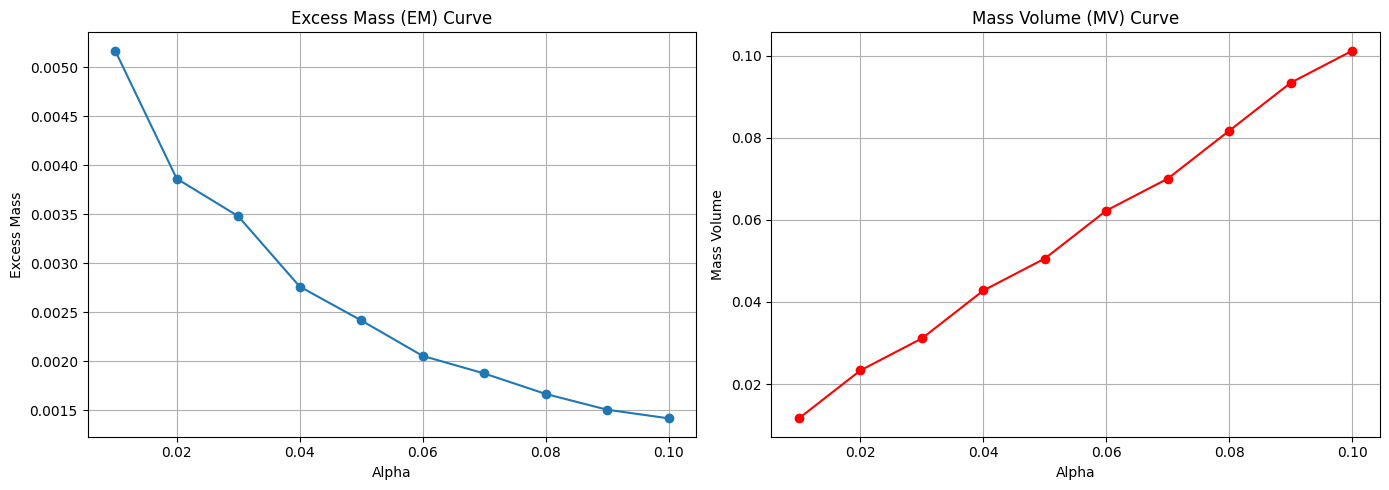

In [ ]:

def plot_em_mv_curves(alpha_vals, em_scores, mv_scores):
    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(alpha_vals, em_scores, marker='o', linestyle='-')
    ax[0].set_title('Excess Mass (EM) Curve')
    ax[0].set_xlabel('Alpha')
    ax[0].set_ylabel('Excess Mass')
    ax[0].grid(True)

    ax[1].plot(alpha_vals, mv_scores, marker='o', linestyle='-', color='red')
    ax[1].set_title('Mass Volume (MV) Curve')
    ax[1].set_xlabel('Alpha')
    ax[1].set_ylabel('Mass Volume')
    ax[1].grid(True)

    plt.tight_layout()
plot_em_mv_curves(alpha_range, em, mv)


## Observations

- **The ROC-AUC score for detecting synthetic anomalies at the window level is extremely high (0.9806)**, which means the model is very accurate at distinguishing between normal and anomalous windows.
- **Excess Mass (EM) Curve:**  
  - As the threshold parameter (alpha) increases, excess mass decreases.
  - This indicates that fewer high-density regions in the score distribution are being considered as anomalies as the threshold is raised.
  - The curve steadily drops, suggesting a smooth and consistent separation between anomalies and normal data.

- **Mass Volume (MV) Curve:**  
  - Mass volume increases as alpha increases.
  - This means that as more data points are considered (by relaxing the threshold), the volume or spread of the region marked abnormal grows.
  - The curve rises smoothly, showing that the model's anomaly scoring expands predictably as the threshold increases.

- **Summary:**  
  - High ROC-AUC demonstrates strong model performance on synthetic anomalies.
  - The shapes of the EM and MV curves confirm that the model’s anomaly detection behavior is stable and well-calibrated over different thresholds.
